In [3]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
from scipy import stats
from scipy import optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use("bmh")
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [5]:
data = pd.read_csv("../data/tutorials/hangout_chat_data.csv")

data.head()

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 02:49:28.552063,Mark Regan,44,2,TEXT,2013-12-19 02:48:50.916592,Daragh Walsh,37.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 02:50:02.249113,Mark Regan,29,2,TEXT,2013-12-19 02:49:50.401824,Daragh Walsh,11.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 02:50:34.906922,Mark Regan,102,2,TEXT,2013-12-19 02:50:11.427353,Daragh Walsh,23.0,1.0,3,2013-12,0


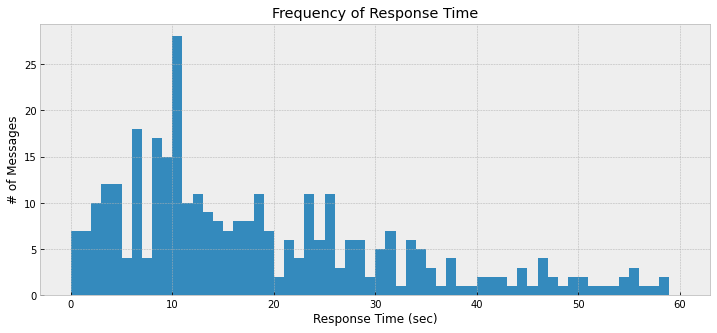

In [7]:
fig = plt.figure(figsize=(12,5))

plt.title("Frequency of Response Time")
plt.xlabel("Response Time (sec)")
plt.ylabel("# of Messages")
plt.hist(data["time_delay_seconds"].values, 
         range=[0,60], 
         bins=60, 
         histtype="stepfilled")
plt.show()

## Traditional Statistics

In [16]:
y_obs = data['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: {}".format(freq_results['x']))

The estimated value of mu is: 18.2307692323807
CPU times: user 224 µs, sys: 37 µs, total: 261 µs
Wall time: 197 µs


/home/liusha/venv/financial_ds/lib/python3.8/site-packages/scipy/optimize/optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


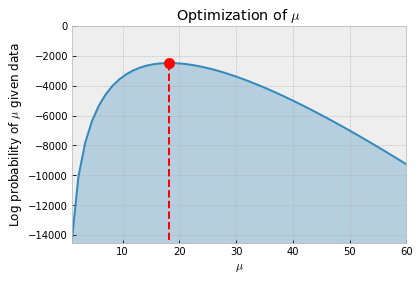

In [17]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

/tmp/ipykernel_29253/2605532650.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mu = np.int(freq_results['x'])


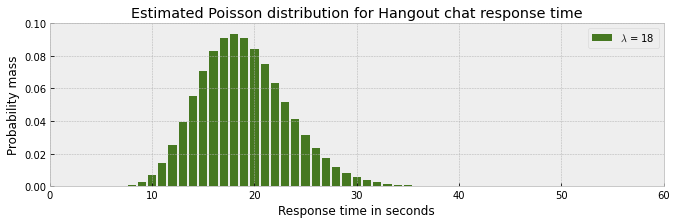

In [18]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

## Bayesian Approach

In [9]:
with pm.Model() as model:
    mu = pm.Uniform("mu", lower=0, upper=60)
    likelihood = pm.Poisson("likelihood", mu=mu, observed=data["time_delay_seconds"].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20_000, step, start=start, progressbar=True)

/tmp/ipykernel_29253/1464873344.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20_000, step, start=start, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/liusha/venv/financial_ds/lib/python3.8/site-packages/scipy/optimize/optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/tmp/ipykernel_29253/2213229797.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, ["mu"], lines={"mu": freq_results})
Got error No model on context stack. trying to find log_likelihood in translation.
/home/liusha/venv/financial_ds/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/home/liusha/venv/f

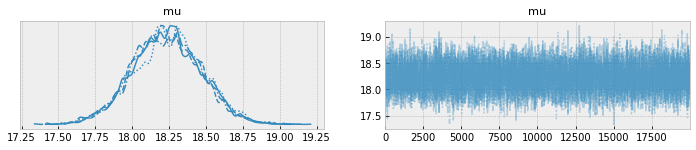

In [15]:
def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(data["time_delay_seconds"].values, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)

pm.traceplot(trace, ["mu"], lines={"mu": freq_results})
plt.show()